In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import sys

from ethp2psim.network import *
from ethp2psim.protocols import *
from ethp2psim.adversary import *
from ethp2psim.simulator import *
from ethp2psim.experiments import run_and_eval, run_experiment

In [3]:
nw_generator = NodeWeightGenerator("random")
ew_generator = EdgeWeightGenerator("normal")

rng = np.random.default_rng(32)
G = nx.random_regular_graph(3,10,seed=rng)
print(list(G.neighbors(0)))
nx.draw(G)

rng = np.random.default_rng(32)
rng.choice(G.nodes(), 3)

net = Network(nw_generator, ew_generator, num_nodes=1000, k=20)

seed = 41
net = Network(nw_generator, ew_generator, num_nodes=10, k=2, seed=seed)

np.mean(list(dict(net.graph.degree).values()))

tor = TOREnhancedProtocol(net, 1, 2, broadcast_mode="all", seed=seed)

np.mean(list(dict(net.graph.degree).values()))

tor.tor_network

msg = Message(0)
adv = Adversary(tor, 0.3, seed=seed)

adv.nodes

msg.queue

msg.process(tor, adv)

list(net.graph.neighbors(4))

# Dandelion example with random seed

In [4]:
seed = 42

In [5]:
net = Network(nw_generator, ew_generator, num_nodes=100, k=20, seed=seed)
dp = DandelionProtocol(net, 0.5, seed=seed)
adv = Adversary(dp, 0.1, seed=seed)

In [6]:
messages = [
    Message(sender)
    for sender in net.sample_random_nodes(
        10,
        replace=True,
        use_weights=True,  # random or stake
        exclude=adv.nodes,
    )
]
sim = Simulator(adv, messages=messages, seed=seed, verbose=False)

sim = Simulator(adv, 10, seed=seed, verbose=False)

from data import GoerliTestnet

net = GoerliTestnet()
net = Network(nw_generator, ew_generator, graph=net.graph, seed=seed)
dp = DandelionProtocol(net, 0.5, seed=seed)
#adv_nodes = net.get_central_nodes(int(net.num_nodes*0.1), "degree")
#adv = Adversary(dp, adversaries=adv_nodes)
adv = Adversary(dp, 0.1, seed=seed)
sim = Simulator(adv, 10, seed=seed, verbose=False)

In [7]:
%%time
_ = sim.run()

CPU times: user 156 ms, sys: 4.11 ms, total: 160 ms
Wall time: 164 ms


In [8]:
%%time
evaluator = Evaluator(sim, "first_reach")
print(evaluator.get_report())

{'estimator': 'first_reach', 'hit_ratio': 0.1, 'inverse_rank': 0.13737777573547277, 'entropy': 0.0, 'ndcg': 0.2808050811503942, 'message_spread_ratio': 1.0}
CPU times: user 12.7 ms, sys: 3.03 ms, total: 15.7 ms
Wall time: 15.3 ms


In [9]:
%%time
evaluator = Evaluator(sim, "first_sent")
print(evaluator.get_report())

{'estimator': 'first_sent', 'hit_ratio': 0.1, 'inverse_rank': 0.13737777573547277, 'entropy': 0.0, 'ndcg': 0.2808050811503942, 'message_spread_ratio': 1.0}
CPU times: user 8.95 ms, sys: 287 µs, total: 9.24 ms
Wall time: 8.76 ms


In [10]:
%%time
evaluator = Evaluator(sim, "dummy")
print(evaluator.get_report())

{'estimator': 'dummy', 'hit_ratio': 0.0, 'inverse_rank': 0.04595118435366552, 'entropy': 6.491853096329675, 'ndcg': 0.20555340573975375, 'message_spread_ratio': 1.0}
CPU times: user 18.9 ms, sys: 3.67 ms, total: 22.5 ms
Wall time: 19.9 ms


# Unittest in the making

In [11]:
import sys, os, pytest

sys.path.insert(0, "%s/python" % os.getcwd())
import networkx as nx
from ethp2psim.network import Network, NodeWeightGenerator, EdgeWeightGenerator
from ethp2psim.simulator import Simulator, Evaluator
from ethp2psim.message import Message
from ethp2psim.protocols import (
    BroadcastProtocol,
    DandelionProtocol,
    DandelionPlusPlusProtocol,
)
from ethp2psim.adversary import Adversary
import pandas as pd

None
[3]
0 1 {1: [ProtocolEvent(1, 1, 0.000000, 0, False, None)]}
1 2 {1: [ProtocolEvent(1, 1, 0.000000, 0, False, None)], 2: [ProtocolEvent(1, 2, 0.900000, 1, True, None)]}
2 2 {1: [ProtocolEvent(1, 1, 0.000000, 0, False, None)], 2: [ProtocolEvent(1, 2, 0.900000, 1, True, None)], 3: [ProtocolEvent(1, 3, 1.840000, 1, True, None)]}
3 2 {1: [ProtocolEvent(1, 1, 0.000000, 0, False, None)], 2: [ProtocolEvent(1, 2, 0.900000, 1, True, None)], 3: [ProtocolEvent(1, 3, 1.840000, 1, True, None)]}


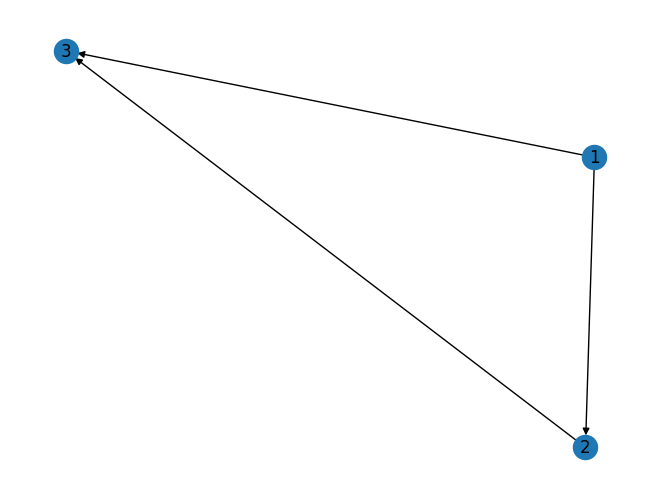

In [12]:
### First sent vs First reach test
rnd_node_weight = NodeWeightGenerator("random")
rnd_edge_weight = EdgeWeightGenerator("random")
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3])
G.add_weighted_edges_from([(1, 2, 0.9), (1, 3, 1.84), (2, 3, 1.01)], weight="latency")
print(nx.draw(G, with_labels=True))
net = Network(rnd_node_weight, EdgeWeightGenerator("custom"), graph=G)
protocol = BroadcastProtocol(net, seed=44, broadcast_mode="all")
adv = Adversary(protocol, ratio=0.0, adversaries=[3])
print(adv.nodes)
assert 3 in adv.nodes

# start a message from Node 1
msg = Message(1)
receiver_order = [1, 2, 2, 2]
for i, receiver in enumerate(receiver_order):
    msg.process(adv)
    print(i, receiver, msg.history)
    assert receiver in msg.history
    # assert len(msg.history) == i + 1

In [13]:
sim = Simulator(adv, 1, True)
sim.run(1.0)
for estimator in ["first_reach", "first_sent"]:
    evaluator = Evaluator(sim, estimator)
    results = [
        evaluator.exact_hits,
        evaluator.ranks,
        evaluator.inverse_ranks,
        evaluator.entropies,
    ]
    for i in results:
        print(estimator, i)

first_reach [1.]
first_reach [1.]
first_reach [1.]
first_reach [0.]
first_sent [1.]
first_sent [1.]
first_sent [1.]
first_sent [0.]


In [14]:
from ethp2psim.experiments import run_and_eval

rnd_node_weight = NodeWeightGenerator("random")
rnd_edge_weight = EdgeWeightGenerator("random")
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3])
G.add_weighted_edges_from([(1, 2, 0.9), (1, 3, 1.84), (2, 3, 0.85)], weight="latency")

net = Network(rnd_node_weight, EdgeWeightGenerator("custom"), graph=G)
protocol = BroadcastProtocol(net, "all", seed=44)
adv = Adversary(protocol, ratio=0.0, adversaries=[3])
sim = Simulator(adv, 1, messages=[Message(1)])

assert 3 in sim.adversary.nodes
assert len(sim.messages) == 1

new_reports = run_and_eval(sim)

sim.messages[0].flush_queue(sim.adversary)

print(new_reports)
assert sim.adversary.predict_msg_source("first_sent").iloc[0][1] == 1
assert sim.adversary.predict_msg_source("first_reach").iloc[0][2] == 1

[{'estimator': 'first_reach', 'hit_ratio': 0.0, 'inverse_rank': 0.5, 'entropy': 0.0, 'ndcg': 0.6309297535714575, 'message_spread_ratio': 1.0, 'mean_contact_time_quantiles': [0.18000000000000002, 0.36000000000000004, 0.54, 0.7200000000000001, 0.9, 1.07, 1.2400000000000002, 1.4100000000000001, 1.58], 'std_contact_time_quantiles': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'adversary': 'Adversary(ratio=0.33, active=False)', 'protocol': 'BroadcastProtocol(broadcast_mode=all)', 'network': 'Network(nw_mode=random, ew_mode=custom, num_nodes=3, k=-1)'}, {'estimator': 'first_sent', 'hit_ratio': 1.0, 'inverse_rank': 1.0, 'entropy': 0.0, 'ndcg': 1.0, 'message_spread_ratio': 1.0, 'mean_contact_time_quantiles': [0.18000000000000002, 0.36000000000000004, 0.54, 0.7200000000000001, 0.9, 1.07, 1.2400000000000002, 1.4100000000000001, 1.58], 'std_contact_time_quantiles': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'adversary': 'Adversary(ratio=0.33, active=False)', 'protocol': 'BroadcastProtocol(b

sim.adversary.predict_msg_source("first_reach")

In [15]:
### Dandelion adversary in the making
H = nx.complete_graph(10)
rnd_node_weight = NodeWeightGenerator("random")
rnd_edge_weight = EdgeWeightGenerator("random")
SEED = 43
net = Network(rnd_node_weight, EdgeWeightGenerator("unweighted"), graph=H, seed=SEED)
protocol = DandelionProtocol(net, 0.4, broadcast_mode="all", seed=SEED + 2)
adv = Adversary(protocol, 0.3)
sim = Simulator(adv, 2)

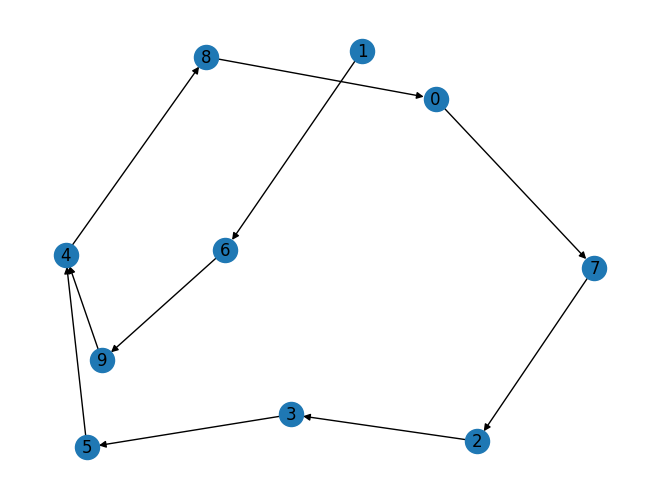

In [16]:
nx.draw(protocol.anonymity_graph, with_labels=True)

In [17]:
adv.nodes

[3, 0, 5]

In [18]:
sim.run(0.9, max_trials=50)

[0.9, 0.9]

In [19]:
sim.messages

[Message(dfc5b22c5340452da5ae04670c172d25, 4),
 Message(f96e304da4e841f7882a7f3811b8b115, 4)]

In [20]:
probabilities = {}
for i in adv.captured_events:
    if i.mid in probabilities.keys():
        continue
    probabilities[i.mid] = [0 for j in range(protocol.network.num_nodes)]

    heardFromStemmingPhase = []
    firstBroadcaster = -1
    ## Who is the first node that reports to the adversary in the stem phase?
    if (
        not i.protocol_event.spreading_phase
        and len(heardFromStemmingPhase) == 0
        and (i.protocol_event.sender not in adv.nodes)
    ):
        heardFromStemmingPhase.append(i.protocol_event.sender)
    ## The first broadcaster the adversary knows about
    if i.protocol_event.spreading_phase and firstBroadcaster == -1:
        firstBroadcaster = i.protocol_event.sender

    shortestPathLength = sys.maxsize
    shortestAdvPath = []
    for k in adv.nodes:
        if heardFromStemmingPhase == []:
            path = nx.shortest_path(protocol.anonymity_graph, k, firstBroadcaster)
        else:
            path = nx.shortest_path(
                protocol.anonymity_graph, k, heardFromStemmingPhase[0]
            )
        if len(path) < shortestPathLength and len(path) != 2:
            shortestAdvPath = path
            shortestPathLength = len(path)
    print("First Broadcaster", firstBroadcaster)

    print(shortestAdvPath)
    probSum = 0  # See Equation 2 here: https://arxiv.org/pdf/2201.11860.pdf
    for node in range(shortestPathLength):
        ## The broadcaster node is not the originator, since in Dandelion the message should have at least 1 hop
        ## We also want to exclude adversarial nodes
        if (
            node != 0
            and shortestAdvPath[shortestPathLength - node - 1] not in adv.nodes
        ):
            probabilities[i.mid][shortestAdvPath[shortestPathLength - node - 1]] = pow(
                protocol.spreading_proba, node
            )
            probSum += pow(protocol.spreading_proba, node)

    for j in range(len(probabilities[i.mid])):
        probabilities[i.mid][j] /= probSum
deanonProbas = pd.DataFrame.from_dict(probabilities, orient="index")
print(deanonProbas)

First Broadcaster -1
[5, 4, 8]
First Broadcaster 8
[5, 4, 8]
                                    0    1    2    3    4    5    6    7    8  \
dfc5b22c5340452da5ae04670c172d25  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
f96e304da4e841f7882a7f3811b8b115  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   

                                    9  
dfc5b22c5340452da5ae04670c172d25  0.0  
f96e304da4e841f7882a7f3811b8b115  0.0  
